In [924]:
import os
import sys
import subprocess
from pathlib import Path

repo_root = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()

sys.path.append(repo_root)

In [925]:
import numpy as np

from matplotlib import pyplot as plt

import json

import utils

from modules import helpers, fitting

import importlib
importlib.reload(utils)
importlib.reload(helpers)
importlib.reload(fitting)

helpers.set_plot_configs()

In [926]:
DataReader = utils.MCAData()

bins, counts, _, _ = DataReader._read_data('data/2025-03-06/recoil_135_0306.Spe')
count_normalizing_factor = np.sum(counts) * (bins[1] - bins[0])
kde_bins, kdes, kdes_err = DataReader._kde_smooth_data(bins, counts, bw=5)
peaks_idx, valleys_idx = DataReader._find_peaks_and_valleys(kde_bins, kdes, kdes_err)

approx_peak_idx = peaks_idx[
    np.argmin(np.abs(bins[peaks_idx] - 1400))
]
approx_peak_bin = bins[approx_peak_idx]
approx_peak_kde = kdes[approx_peak_idx]

lower_idx, upper_idx = DataReader._get_fitting_boundaries(bins,kdes,peaks_idx,valleys_idx,
                                                          approx_peak_bin,approx_peak_bin,
                                                          threshold=approx_peak_kde/3,threshold_ratio=1,
                                                          outward=False)

In [927]:
calibration = utils.MCACalibration('data/2025-03-04/Calibration_scatter_na_0304.Spe',
                                   'data/2025-03-04/Calibration_scatter_ba_0304.Spe',
                                   kernel_bw=5,
                                   cs_137_approx_line_bin=None,)

In [928]:
compton = utils.MCACompton(data_base='135_0306.Spe',data_dir='data/2025-03-06/',)

peak_mu_count, peak_mu_count_err, peak_sigma_count, peak_sigma_count_err, \
peak_mu_energy, peak_mu_energy_err, peak_sigma_energy, peak_sigma_count_err, \
fitting_bins, fitted_counts = compton._peak_analysis('recoil')
print(peak_mu_count, peak_mu_count_err, peak_sigma_count, peak_sigma_count_err)

[1230.83487387] [1.89746087] [52.12436383] [2.53848767]


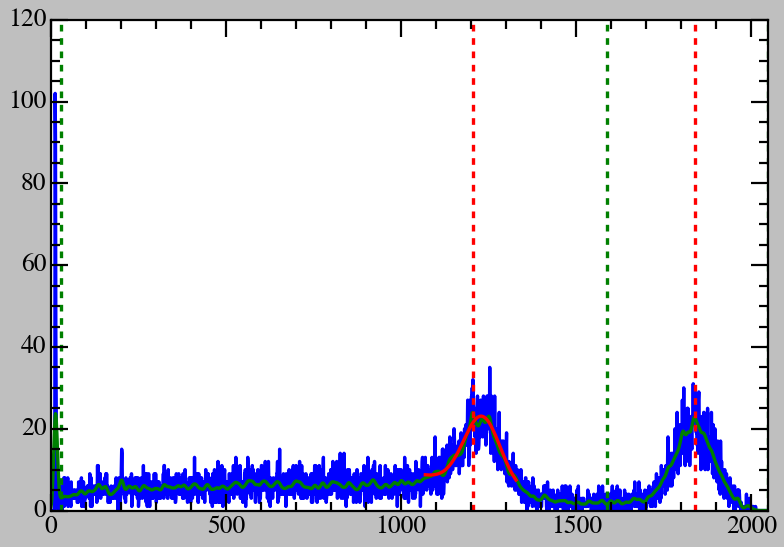

In [929]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(bins, counts)
ax.plot(kde_bins, kdes*count_normalizing_factor)
# ax.errorbar(kde_bins, kde, yerr=kde_err,
#             fmt=' s',markersize=1,elinewidth=2,capsize=5)

for peak_idx in peaks_idx:
    ax.axvline(kde_bins[peak_idx], color='r', linestyle='--')
for valley_idx in valleys_idx:
    ax.axvline(kde_bins[valley_idx], color='g', linestyle='--')

# ax.axvline(kde_bins[lower_idx], color='b', linestyle='--')
# ax.axvline(kde_bins[upper_idx], color='b', linestyle='--')

ax.plot(fitting_bins, fitted_counts, color='r')

# for fitting_bins, gaussian_counts in zip(calibration.ba_133_fitting_bins+[calibration.cs_137_fitting_bins],
#                                          calibration.ba_133_fitted_counts+[calibration.cs_137_fitted_counts]):
#     if fitting_bins is not None:
#         ax.plot(fitting_bins, gaussian_counts/count_normalizing_factor, color='r')

ax.set_xscale('linear')
# ax.set_yscale('log')

ax.set_xlim(0, 2048)
#ax.set_ylim(0, 7000)

plt.tight_layout()
plt.show()

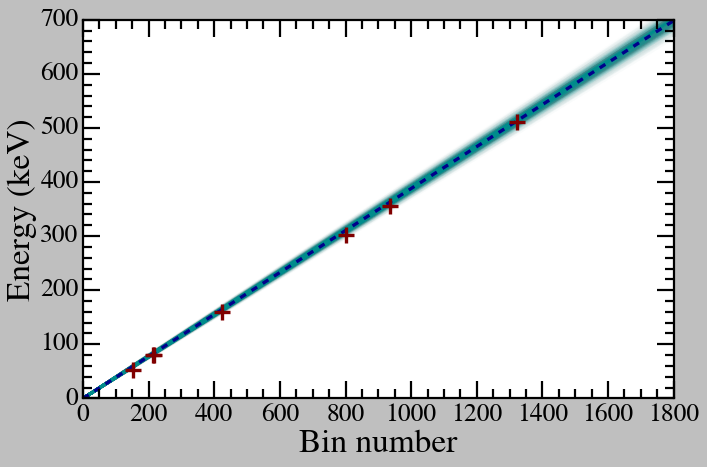

In [930]:
fig, ax = plt.subplots(figsize=(9, 6))

ax.scatter(calibration.calib_bins, calibration.calib_energies, marker='+', s=200, color='maroon', zorder=-1)

bins_dense = np.linspace(0, 1800, 1000)
ax.plot(bins_dense, calibration.energy_scaler*bins_dense, color='darkblue', ls='--',zorder=-2)

for i in range(500):
    scaler = np.random.normal(calibration.energy_scaler,calibration.energy_scaler_err)

    ax.plot(bins_dense, scaler*bins_dense, color='darkcyan', alpha=0.01, zorder=-3)

ax.set_xlabel('Bin number')
ax.set_ylabel('Energy (keV)')

ax.set_xlim(0, 1800)
ax.set_ylim(0, 700)

plt.tight_layout()
plt.show()

In [931]:
data = {
    0 : ['0_0304.Spe','data/2025-03-04'],
    30 : ['30_0304.Spe','data/2025-03-04'],
    60 : ['60_0304.Spe','data/2025-03-04'],
    90 : ['90_0304.Spe','data/2025-03-04'],
    120 : ['120_0304.Spe','data/2025-03-04'],

    15 : ['15_0306.Spe','data/2025-03-06'],
    45 : ['45_0306.Spe','data/2025-03-06'],
    75 : ['75_0306.Spe','data/2025-03-06'],
    105 : ['105_0306.Spe','data/2025-03-06'],
    135 : ['135_0306.Spe','data/2025-03-06'],
}

angles = np.linspace(0,135,10)
electron_energies = np.array([])
electron_energies_err = np.array([])
photon_energies = np.array([])
photon_energies_err = np.array([])

for angle in angles:
    data_base, data_dir = data[angle]
    compton_data = utils.MCACompton(data_base=data_base,data_dir=data_dir)
    _, _, _, _, \
    peak_mu_energy, peak_mu_energy_err, peak_sigma_energy, peak_sigma_count_err, \
    fitting_bins, fitted_counts = compton_data._peak_analysis('recoil')

    electron_energies = np.append(electron_energies, peak_mu_energy)
    electron_energies_err = np.append(electron_energies_err, peak_mu_energy_err)

    _, _, _, _, \
    peak_mu_energy, peak_mu_energy_err, peak_sigma_energy, peak_sigma_count_err, \
    fitting_bins, fitted_counts = compton_data._peak_analysis('scatter')

    photon_energies = np.append(photon_energies, peak_mu_energy)
    photon_energies_err = np.append(photon_energies_err, peak_mu_energy_err)

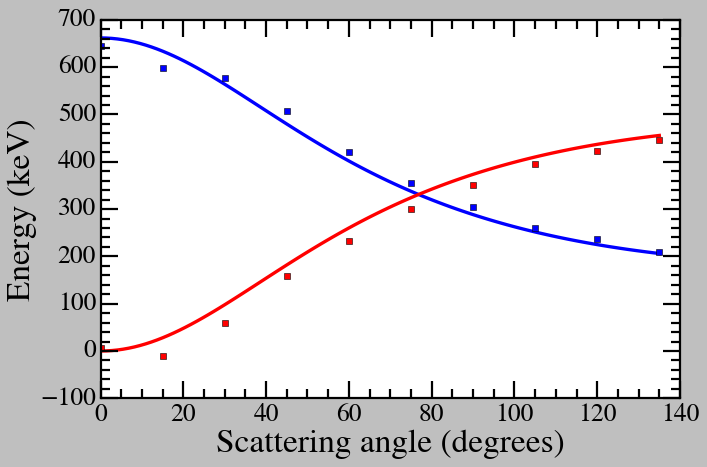

In [937]:
fig, ax = plt.subplots(figsize=(9, 6))

angle_array = np.linspace(0,135,100)

expected_photon_energies = 661.7 / (1 + 661.66/511 * (1 - np.cos(np.radians(angle_array))))
expected_electron_energies = 661.7 - expected_photon_energies

ax.errorbar(angles, photon_energies, fmt=' s', markersize=5, elinewidth=2, capsize=5, color='b', label='Photon energy')
ax.errorbar(angles, electron_energies, fmt=' s', markersize=5, elinewidth=2, capsize=5, color='r', label='Electron energy')

ax.plot(angle_array, expected_photon_energies, color='b')
ax.plot(angle_array, expected_electron_energies, color = 'r')

ax.set_xlabel('Scattering angle (degrees)')
ax.set_ylabel('Energy (keV)')

#ax.legend()

plt.tight_layout()
plt.show()